## Benchmark loading CELLxGENE Census data in Pytorch

Run this notebook via [Papermill](https://papermill.readthedocs.io/en/latest/) / the [`execute-nb`](https://github.com/ryan-williams/arrayloader-benchmarks/blob/main/execute-nb) wrapper

```bash
./execute-nb us-east-1  # from a g4dn.8xlarge in us-east-1
./execute-nb us-west-2  # from a g4dn.8xlarge in us-west-2
./execute-nb local-nvme -p census_uri '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
./execute-nb subset-nvme -p experiment_uri '/mnt/nvme/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
./execute-nb subset-gp3 -p experiment_uri 'data/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
```
See [README](https://github.com/ryan-williams/arrayloader-benchmarks?tab=readme-ov-file#census-timing-vs-data-locality) for more info.

**⚠️ This notebook was run with a modified `cellxgene_census` library; see [`main...ryan-williams:cellxgene-census`](https://github.com/chanzuckerberg/cellxgene-census/compare/main...ryan-williams:cellxgene-census:stats?expand=1) ⚠️**

In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
from cellxgene_census.experimental.ml.pytorch import pytorch_logger
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set this to read from a local path
experiment_uri = 'data/census-benchmark_2:7'

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `subset` if `experiment_uri` is a local path
# - `local` if `census_uri` is a local path
# - current (EC2 instance) region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
name = 'subset-gp3-dbg'

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024

# Defaults to 20_000 when fetching from S3. Local subsets (when `experiment_uri` is set)
# are assumed to have already been var-sliced.
n_vars = None

soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True
progress_bar = True
torch_log_level = "DEBUG"

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
name = "subset-gp3"
progress_bar = False


In [4]:
pytorch_logger.setLevel(torch_log_level)

In [5]:
if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    with profile('open'):
        experiment = Experiment.open(experiment_uri)
    obs_query = None
    var_query = None
    if name is None:
        scheme = urlparse(experiment_uri).scheme
        if is_local(experiment_uri):
            name = 'subset'
else:
    if not census_uri:
        census_uri = None
    
    if name is None:
        if census_uri and is_local(census_uri):
            name = 'local'
        else:
            name = get_region()
    
    err(f"Loading census ({name})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_dataset_ids(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)
    if n_vars is None:
        n_vars = 20_000
    var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if not name:
    raise ValueError("`name` not set")

experiment

Loading experiment data/census-benchmark_2:7


<Experiment 'data/census-benchmark_2:7' (open for 'r') (2 items)
    'obs': 'file:///home/ec2-user/arrayloader-benchmarks/data/census-benchmark_2:7/obs' (unopened)
    'ms': 'file:///home/ec2-user/arrayloader-benchmarks/data/census-benchmark_2:7/ms' (unopened)>

In [6]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 241 µs, sys: 4.03 ms, total: 4.27 ms
Wall time: 3.9 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7fa446af6d10>)

In [7]:
%%time
print(f"Data shape: {exp.datapipe.shape}, pid {os.getpid()}")

Initializing ExperimentDataPipe


Initializing encoders


Data shape: (133790, 20000), pid 23514
CPU times: user 68.8 ms, sys: 30 ms, total: 98.9 ms
Wall time: 38.5 ms


## Run benchmark

In [8]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(
            exp,
            batch_size=batch_size,
            gc_freq=gc_freq,
            exclude_first_batch=exclude_first_batch,
            progress_bar=progress_bar,
        )
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

Using self.soma_chunk_size=10000


Shuffling 133790 obs joinids into 14 chunks of 10000


Process 23514 handling partition 1 of 1, partition_size=133790


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=1906778112, vms=25984286720, shared=543485952, text=3342336, lib=0, data=10635882496, dirty=0, uss=1866719232, pss=1881084928, swap=0), svmem(total=133636747264, available=129455206400, percent=3.1, used=2901790720, free=111138603008, active=8114593792, inactive=12500934656, buffers=2768896, cached=19593584640, shared=13348864, slab=1137565696), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=1907617792, vms=26005262336, shared=543485952, text=3342336, lib=0, data=10672599040, dirty=0, uss=1869774848, pss=1884150784, swap=0), svmem(total=133636747264, available=129452744704, percent=3.1, used=2904252416, free=111136141312, active=8116785152, inactive=12500934656, buffers=2768896, cached=19593584640, shared=13348864, slab=1137467392), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=33892022, elapsed=0:00:04.019550


Retrieved SOMA chunk totals: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=33892022, elapsed=0:00:04.019550, gc_elapsed=0:00:00.130967


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4414926848, vms=33097240576, shared=546684928, text=3342336, lib=0, data=16373112832, dirty=0, uss=4379938816, pss=4394380288, swap=0), svmem(total=133636747264, available=126945193984, percent=5.0, used=5411803136, free=108627566592, active=10622963712, inactive=12500770816, buffers=2768896, cached=19594608640, shared=13348864, slab=1138704384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4414926848, vms=33097240576, shared=546684928, text=3342336, lib=0, data=16373112832, dirty=0, uss=4379938816, pss=4394380288, swap=0), svmem(total=133636747264, available=126945193984, percent=5.0, used=5411803136, free=108627566592, active=10622963712, inactive=12500770816, buffers=2768896, cached=19594608640, shared=13348864, slab=1138704384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=33919521, elapsed=0:00:04.143854


Retrieved SOMA chunk totals: self.n_soma_chunks=2, self.n_obs=19113, self.nnz=67811543, elapsed=0:00:08.163404, gc_elapsed=0:00:00.272438


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5388173312, vms=37049352192, shared=546684928, text=3342336, lib=0, data=19991142400, dirty=0, uss=5353320448, pss=5367761920, swap=0), svmem(total=133636747264, available=125969690624, percent=5.7, used=6387306496, free=107652063232, active=11596296192, inactive=12500770816, buffers=2768896, cached=19594608640, shared=13348864, slab=1138704384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3221446656, vms=32993529856, shared=546684928, text=3342336, lib=0, data=15935320064, dirty=0, uss=3186593792, pss=3201035264, swap=0), svmem(total=133636747264, available=128139296768, percent=4.1, used=4217700352, free=109821669376, active=9429626880, inactive=12500770816, buffers=2768896, cached=19594608640, shared=13348864, slab=1138704384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=16207697, elapsed=0:00:02.268058


Retrieved SOMA chunk totals: self.n_soma_chunks=3, self.n_obs=28669, self.nnz=84019240, elapsed=0:00:10.431463, gc_elapsed=0:00:00.450883


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4877275136, vms=37107281920, shared=546684928, text=3342336, lib=0, data=19782782976, dirty=0, uss=4843732992, pss=4858174464, swap=0), svmem(total=133636747264, available=126480519168, percent=5.4, used=5876477952, free=108162891776, active=11086409728, inactive=12500770816, buffers=2768896, cached=19594608640, shared=13348864, slab=1138704384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3630862336, vms=33496641536, shared=546684928, text=3342336, lib=0, data=16172142592, dirty=0, uss=3597320192, pss=3611761664, swap=0), svmem(total=133636747264, available=127727738880, percent=4.4, used=4629258240, free=109410111488, active=9839947776, inactive=12500770816, buffers=2768896, cached=19594608640, shared=13348864, slab=1138704384), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=25249271, elapsed=0:00:03.193629


Retrieved SOMA chunk totals: self.n_soma_chunks=4, self.n_obs=38226, self.nnz=109268511, elapsed=0:00:13.625092, gc_elapsed=0:00:00.617591


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5794787328, vms=37660033024, shared=546684928, text=3342336, lib=0, data=20068630528, dirty=0, uss=5761032192, pss=5775302656, swap=0), svmem(total=133636747264, available=125518397440, percent=6.1, used=6838554624, free=107199492096, active=12047626240, inactive=12501929984, buffers=2768896, cached=19595931648, shared=13348864, slab=1138827264), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4116905984, vms=33802792960, shared=546684928, text=3342336, lib=0, data=16211390464, dirty=0, uss=4083150848, pss=4097421312, swap=0), svmem(total=133636747264, available=127198162944, percent=4.8, used=5158834176, free=108860936192, active=10370170880, inactive=12519608320, buffers=2768896, cached=19614208000, shared=13348864, slab=1139482624), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=31183978, elapsed=0:00:03.994303


Retrieved SOMA chunk totals: self.n_soma_chunks=5, self.n_obs=47783, self.nnz=140452489, elapsed=0:00:17.619395, gc_elapsed=0:00:00.796526


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5963132928, vms=38672953344, shared=546684928, text=3342336, lib=0, data=20814356480, dirty=0, uss=5929963520, pss=5944404992, swap=0), svmem(total=133636747264, available=125381595136, percent=6.2, used=6975410176, free=107015864320, active=12172931072, inactive=12545994752, buffers=2768896, cached=19642703872, shared=13348864, slab=1142030336), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4038344704, vms=34684149760, shared=546684928, text=3342336, lib=0, data=16825552896, dirty=0, uss=4005175296, pss=4019616768, swap=0), svmem(total=133636747264, available=127307505664, percent=4.7, used=5049499648, free=108941774848, active=10250084352, inactive=12545994752, buffers=2768896, cached=19642703872, shared=13348864, slab=1142030336), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=27197660, elapsed=0:00:03.295157


Retrieved SOMA chunk totals: self.n_soma_chunks=6, self.n_obs=57339, self.nnz=167650149, elapsed=0:00:20.914552, gc_elapsed=0:00:00.979501


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4920520704, vms=38452097024, shared=546684928, text=3342336, lib=0, data=20392579072, dirty=0, uss=4874907648, pss=4889340928, swap=0), svmem(total=133636747264, available=126547587072, percent=5.3, used=5926862848, free=108064403456, active=11016986624, inactive=12661907456, buffers=2768896, cached=19642712064, shared=13348864, slab=1142009856), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3559538688, vms=34576031744, shared=546684928, text=3342336, lib=0, data=16516513792, dirty=0, uss=3526971392, pss=3541412864, swap=0), svmem(total=133636747264, available=127906119680, percent=4.3, used=4568330240, free=109422936064, active=9654960128, inactive=12661907456, buffers=2768896, cached=19642712064, shared=13348864, slab=1142009856), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=14032495, elapsed=0:00:01.963885


Retrieved SOMA chunk totals: self.n_soma_chunks=7, self.n_obs=66895, self.nnz=181682644, elapsed=0:00:22.878437, gc_elapsed=0:00:01.152538


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4762492928, vms=38386823168, shared=546684928, text=3342336, lib=0, data=20327903232, dirty=0, uss=4729630720, pss=4744072192, swap=0), svmem(total=133636747264, available=126625632256, percent=5.2, used=5764919296, free=108226347008, active=10940915712, inactive=12578009088, buffers=2768896, cached=19642712064, shared=13348864, slab=1142149120), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3559698432, vms=34812452864, shared=546684928, text=3342336, lib=0, data=16753532928, dirty=0, uss=3526836224, pss=3541277696, swap=0), svmem(total=133636747264, available=127908265984, percent=4.3, used=4561002496, free=109430263808, active=9659207680, inactive=12656726016, buffers=2768896, cached=19642712064, shared=13348864, slab=1142149120), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=24919121, elapsed=0:00:03.204135


Retrieved SOMA chunk totals: self.n_soma_chunks=8, self.n_obs=76452, self.nnz=206601765, elapsed=0:00:26.082572, gc_elapsed=0:00:01.329495


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6113443840, vms=39025868800, shared=546684928, text=3342336, lib=0, data=20967219200, dirty=0, uss=6081413120, pss=6095854592, swap=0), svmem(total=133636747264, available=125236154368, percent=6.3, used=7124000768, free=106867257344, active=12323381248, inactive=12547629056, buffers=2768896, cached=19642720256, shared=13348864, slab=1142124544), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4328615936, vms=35186601984, shared=546684928, text=3342336, lib=0, data=17127952384, dirty=0, uss=4296585216, pss=4311026688, swap=0), svmem(total=133636747264, available=127023226880, percent=4.9, used=5336928256, free=108654329856, active=10538225664, inactive=12547629056, buffers=2768896, cached=19642720256, shared=13348864, slab=1142190080), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=35898436, elapsed=0:00:04.478140


Retrieved SOMA chunk totals: self.n_soma_chunks=9, self.n_obs=86008, self.nnz=242500201, elapsed=0:00:30.560711, gc_elapsed=0:00:01.513218


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5824860160, vms=38905085952, shared=546684928, text=3342336, lib=0, data=20847046656, dirty=0, uss=5792665600, pss=5807107072, swap=0), svmem(total=133636747264, available=125528526848, percent=6.1, used=6828478464, free=107162763264, active=12037074944, inactive=12544491520, buffers=2768896, cached=19642736640, shared=13348864, slab=1142202368), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3715846144, vms=34743099392, shared=546684928, text=3342336, lib=0, data=16685060096, dirty=0, uss=3683602432, pss=3698043904, swap=0), svmem(total=133636747264, available=127640420352, percent=4.5, used=4716584960, free=109274656768, active=9928179712, inactive=12544491520, buffers=2768896, cached=19642736640, shared=13348864, slab=1142202368), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=19339142, elapsed=0:00:02.467863


Retrieved SOMA chunk totals: self.n_soma_chunks=10, self.n_obs=95564, self.nnz=261839343, elapsed=0:00:33.028575, gc_elapsed=0:00:01.689265


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5213388800, vms=38637948928, shared=546684928, text=3342336, lib=0, data=20580610048, dirty=0, uss=5181628416, pss=5196069888, swap=0), svmem(total=133636747264, available=126140760064, percent=5.6, used=6216245248, free=107774996480, active=11426078720, inactive=12544491520, buffers=2768896, cached=19642736640, shared=13348864, slab=1142185984), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3807354880, vms=34929721344, shared=546684928, text=3342336, lib=0, data=16872382464, dirty=0, uss=3775594496, pss=3790035968, swap=0), svmem(total=133636747264, available=127548669952, percent=4.6, used=4808335360, free=109182906368, active=10020134912, inactive=12544491520, buffers=2768896, cached=19642736640, shared=13348864, slab=1142185984), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=27269678, elapsed=0:00:03.356158


Retrieved SOMA chunk totals: self.n_soma_chunks=11, self.n_obs=105121, self.nnz=289109021, elapsed=0:00:36.384732, gc_elapsed=0:00:01.872976


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6309937152, vms=39135772672, shared=546684928, text=3342336, lib=0, data=21079425024, dirty=0, uss=6277955584, pss=6292397056, swap=0), svmem(total=133636747264, available=125043953664, percent=6.4, used=7313051648, free=106678190080, active=12522819584, inactive=12544491520, buffers=2768896, cached=19642736640, shared=13348864, slab=1142194176), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4344872960, vms=35233792000, shared=546684928, text=3342336, lib=0, data=17177444352, dirty=0, uss=4312891392, pss=4327332864, swap=0), svmem(total=133636747264, available=127009886208, percent=5.0, used=5347119104, free=108644122624, active=10559299584, inactive=12544491520, buffers=2768896, cached=19642736640, shared=13348864, slab=1142194176), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=34774431, elapsed=0:00:04.331068


Retrieved SOMA chunk totals: self.n_soma_chunks=12, self.n_obs=114678, self.nnz=323883452, elapsed=0:00:40.715801, gc_elapsed=0:00:02.057564


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6429523968, vms=39207432192, shared=546684928, text=3342336, lib=0, data=21151883264, dirty=0, uss=6398222336, pss=6412663808, swap=0), svmem(total=133636747264, available=124928311296, percent=6.5, used=7433940992, free=106557300736, active=12637302784, inactive=12549738496, buffers=2768896, cached=19642736640, shared=13348864, slab=1142194176), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4246257664, vms=35151548416, shared=546684928, text=3342336, lib=0, data=17095999488, dirty=0, uss=4214956032, pss=4229397504, swap=0), svmem(total=133636747264, available=127114518528, percent=4.9, used=5247733760, free=108743507968, active=10454151168, inactive=12549738496, buffers=2768896, cached=19642736640, shared=13348864, slab=1142194176), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=29214437, elapsed=0:00:03.368509


Retrieved SOMA chunk totals: self.n_soma_chunks=13, self.n_obs=124234, self.nnz=353097889, elapsed=0:00:44.084310, gc_elapsed=0:00:02.248535


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5222559744, vms=38760202240, shared=546684928, text=3342336, lib=0, data=20704751616, dirty=0, uss=5190643712, pss=5205085184, swap=0), svmem(total=133636747264, available=126303944704, percent=5.5, used=6226083840, free=107765157888, active=11262472192, inactive=12717514752, buffers=2768896, cached=19642736640, shared=13348864, slab=1142202368), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3486674944, vms=34668478464, shared=546684928, text=3342336, lib=0, data=16613634048, dirty=0, uss=3454763008, pss=3469204480, swap=0), svmem(total=133636747264, available=128042672128, percent=4.2, used=4487356416, free=109503885312, active=9526263808, inactive=12717514752, buffers=2768896, cached=19642736640, shared=13348864, slab=1142202368), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=17489698, elapsed=0:00:02.371468


Retrieved SOMA chunk totals: self.n_soma_chunks=14, self.n_obs=133790, self.nnz=370587587, elapsed=0:00:46.455778, gc_elapsed=0:00:02.414946


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=3591786496, vms=34841583616, shared=546684928, text=3342336, lib=0, data=16786739200, dirty=0, uss=3559874560, pss=3574316032, swap=0), svmem(total=133636747264, available=127931342848, percent=4.3, used=4598685696, free=109392535552, active=9632624640, inactive=12717510656, buffers=2768896, cached=19642757120, shared=13348864, slab=1142157312), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=2555629568, vms=31171407872, shared=546684928, text=3342336, lib=0, data=13116563456, dirty=0, uss=2523717632, pss=2538159104, swap=0), svmem(total=133636747264, available=128800985088, percent=3.6, used=3561267200, free=110429954048, active=8764334080, inactive=12549734400, buffers=2768896, cached=19642757120, shared=13348864, slab=1142157312), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc:  pre=(pfullmem(rss=2448334848, vms=31143067648, shared=546684928, text=3342336, lib=0, data=13088223232, dirty=0, uss=2495860736, pss=2510302208, swap=0), svmem(total=133636747264, available=128996728832, percent=3.5, used=3462549504, free=110528671744, active=8569204736, inactive=12646760448, buffers=2768896, cached=19642757120, shared=13348864, slab=1142157312), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=2360004608, vms=31143067648, shared=546684928, text=3342336, lib=0, data=13088223232, dirty=0, uss=2328084480, pss=2342525952, swap=0), svmem(total=133636747264, available=128997261312, percent=3.5, used=3364990976, free=110626230272, active=8568651776, inactive=12549734400, buffers=2768896, cached=19642757120, shared=13348864, slab=1142280192), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


max process memory usage=5.959 GiB


time per sample: 327.24 μs
samples per sec: 3055.90 samples/sec
CPU times: user 1min 13s, sys: 35.6 s, total: 1min 49s
Wall time: 48 s


In [9]:
exp_stats = experiment_datapipe.stats()
checkpoints_df = exp_stats.checkpoints_df()
checkpoints_df

,obs_joinids_chunk,obs_batch,obs_batch_reindex,scipy_iter,X_batch
0,0.000520,0.176328,0.001201,0.002991,3.838478
1,0.000180,0.050734,0.000875,0.004128,4.087913
2,0.000263,0.021986,0.000595,0.003157,2.242034
3,0.000410,0.023979,0.001258,0.003942,3.164015
4,0.000251,0.023711,0.000965,0.004351,3.965002
5,0.000431,0.023233,0.000618,0.003357,3.267495
6,0.000248,0.025471,0.001424,0.005577,1.931142
7,0.000201,0.025522,0.000830,0.004630,3.172929
8,0.000423,0.021832,0.000564,0.003192,4.452107
9,0.000418,0.022145,0.000750,0.003654,2.440875


## CxG `pytorch.py` latency
Total latency from various chunks in [CxG `_ObsAndXSOMAIterator`](https://github.com/ryan-williams/cellxgene-census/blob/a0fa2449a9f9858edd3befee3c9fb46f84c2cf44/api/python/cellxgene_census/src/cellxgene_census/experimental/ml/pytorch.py#L162-L212):

In [10]:
checkpoints_df.sum()

obs_joinids_chunk     0.005512
obs_batch             0.505189
obs_batch_reindex     0.011981
scipy_iter            0.057895
X_batch              45.874877
dtype: float64

## `tiledbsoma` latency
Measured by `tiledbsoma_stats_*`:

In [11]:
timers_df, counters_df = stats.dfs
timers_df['sum'].sum()

8.401237365

In [12]:
timers_df.groupby(['source', 'name'])['sum'].sum()

source      name   
tiledb      open       0.000457
tiledbsoma  X_batch    8.400438
            open       0.000343
Name: sum, dtype: float64

### `tiledb{,soma}` timer/counter DataFrames

In [13]:
timers_df

,key,avg,sum,num,name,source
0,Context.StorageManager.load_group_from_all_uris,0.000124,0.000124,1,open,tiledb
1,Context.StorageManager.load_group_details,0.000129,0.000129,1,open,tiledb
2,Context.StorageManager.group_open_for_reads,0.000131,0.000131,1,open,tiledb
3,Context.StorageManager.group_load_metadata_fro...,0.000074,0.000074,1,open,tiledb
4,Context.StorageManager.load_group_from_all_uris,0.000091,0.000091,1,open,tiledbsoma
...,...,...,...,...,...,...
381,Context.StorageManager.Query.Reader.create_res...,0.000529,0.000529,1,X_batch,tiledbsoma
382,Context.StorageManager.Query.Reader.copy_fixed...,0.005973,0.017920,3,X_batch,tiledbsoma
383,Context.StorageManager.Query.Reader.compute_ti...,0.009012,0.009012,1,X_batch,tiledbsoma
384,Context.StorageManager.Query.Reader.compute_re...,0.000928,0.035265,38,X_batch,tiledbsoma


In [14]:
counters_df

,key,num,name,source
0,Context.StorageManager.read_unfiltered_byte_num,262,open,tiledb
1,Context.StorageManager.read_group_size,70,open,tiledb
2,Context.StorageManager.group_read_group_meta_size,192,open,tiledb
3,Context.StorageManager.VFS.read_ops_num,6,open,tiledb
4,Context.StorageManager.VFS.read_byte_num,333,open,tiledb
...,...,...,...,...
288,Context.StorageManager.Query.Reader.dim_num,2,X_batch,tiledbsoma
289,Context.StorageManager.Query.Reader.dim_fixed_num,2,X_batch,tiledbsoma
290,Context.StorageManager.Query.Reader.cell_num,19500000,X_batch,tiledbsoma
291,Context.StorageManager.Query.Reader.attr_num,1,X_batch,tiledbsoma


## Save batch timings, `tiledb{,soma}` stats

In [15]:
results_json_path = f'results/{name}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/subset-gp3.json


In [16]:
makedirs('tdb', exist_ok=True)
timers_path = f'tdb/{name}-timers.csv'
timers_df.sort_values('key').to_csv(timers_path)
counters_path = f'tdb/{name}-counters.csv'
counters_df.sort_values('key').to_csv(counters_path)

In [17]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [18]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_23514/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.250258
1,1,0.166497
2,2,0.166705
3,3,0.211116
4,4,0.167500
...,...,...
125,125,0.100397
126,126,0.101162
127,127,0.101148
128,128,0.099889


In [19]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
8,8,2.711623
17,17,0.930343
26,26,1.912794
36,36,2.603803
45,45,1.878824
54,54,0.651343
64,64,1.986335
73,73,3.117478
82,82,1.059114
92,92,2.033076


In [20]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-subset-gp3.png


Returning IPython Image


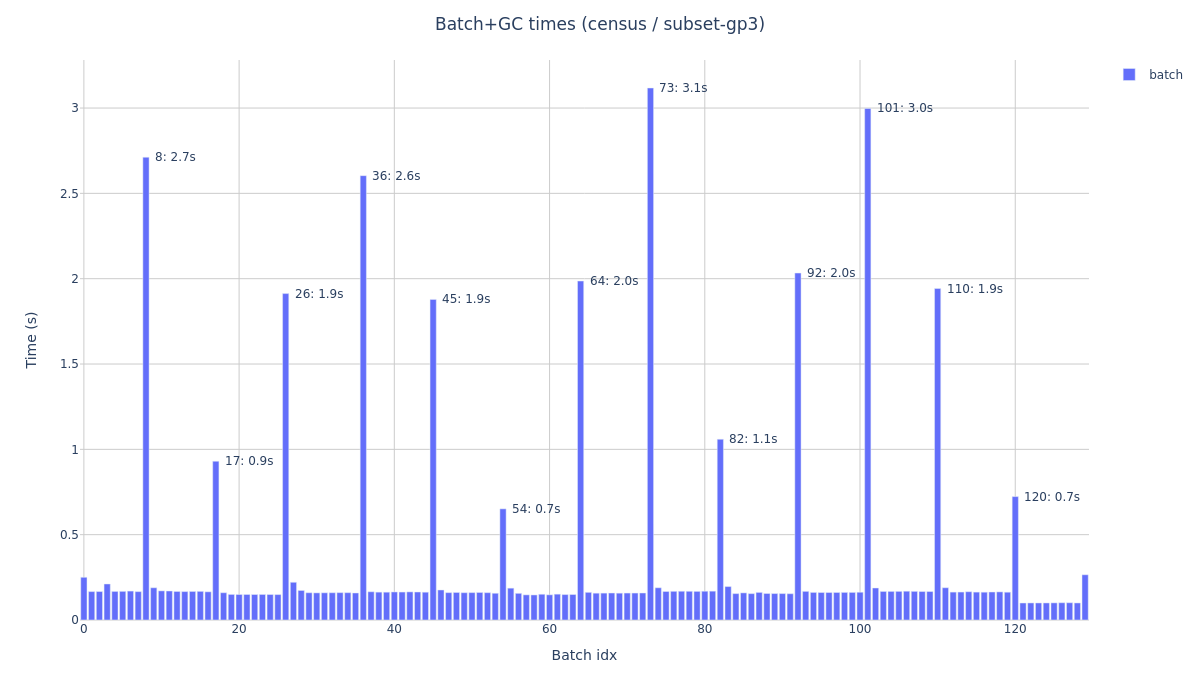

In [21]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {name})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{name}', fmt='png', save=['png'], w=width, h=height, dir='img',)